In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from preprocessing import StandardScaler, Create_Matrix, Split
from model import Net
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

In [7]:
timesteps = 90
baggings = 20
total = 0

In [6]:
data = pd.read_csv('bdi.csv')['bdi'].fillna(method='ffill').values[-750:]
eemd = [np.load(f'EEMD/EEMD{i}.npy').reshape(11, -1, 1) for i in range(1524)]

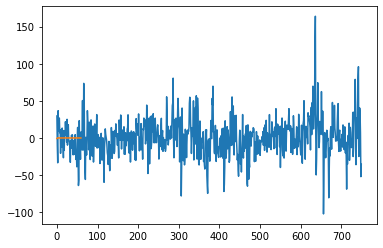

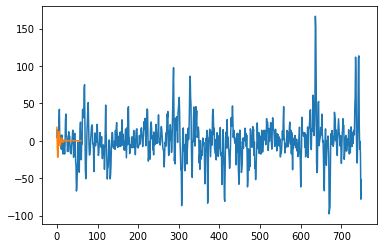

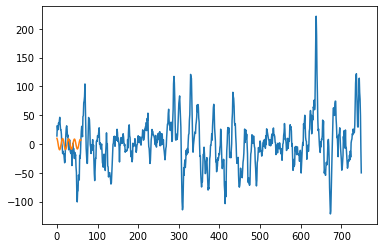

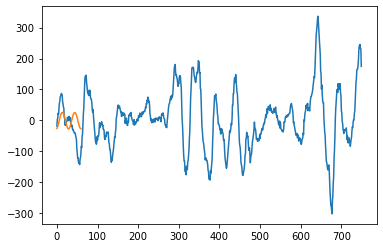

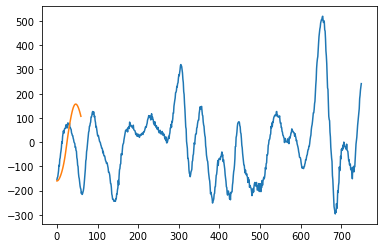

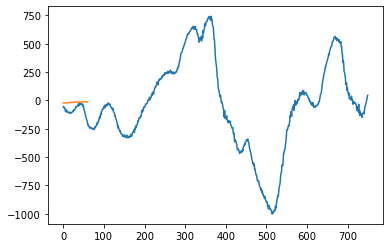

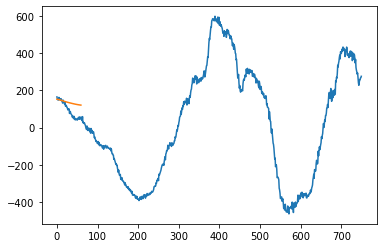

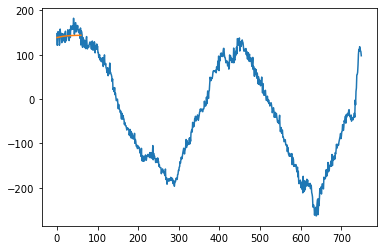

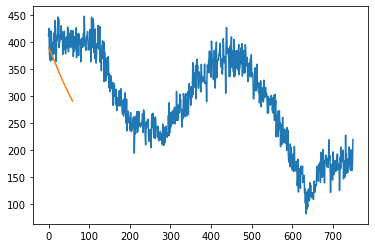

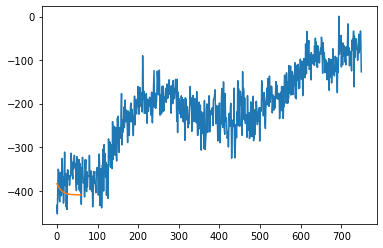

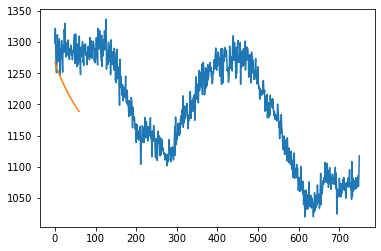

In [9]:
for mode in range(11):
    x_train, y_train, x_test, y_test = Create_Matrix(mode, eemd, timesteps)
    x_train, y_train, x_val, y_val, x_test, y_test = Split(x_train, y_train, x_test, y_test)

    scaler = StandardScaler(y_train)
    y_train = scaler.transform(y_train)
    x_train = scaler.transform(x_train)
    y_val = scaler.transform(y_val)
    x_val = scaler.transform(x_val)
    x_test = scaler.transform(x_test)

    x_test = torch.FloatTensor(x_test[0]).to(device)

    ls = []
    for _ in range(60):
        pred = 0
        for i in range(20):
            tmp = x_test[-timesteps:]
            model = Net().to(device)
            model = torch.load(f'mode{mode:02d}/{i}.pt')
            model.eval()
            with torch.no_grad():
                tmp = tmp[-timesteps:]
                pred += model(tmp.view(1, timesteps, 1))
        pred = pred / baggings
        ls.append(pred.cpu().numpy())
        x_test = torch.cat((x_test, pred))
    Pred = scaler.inverse_transform(np.array(ls).reshape(-1))
    total += Pred
    plt.plot(y_test)
    plt.plot(Pred)
    plt.show()

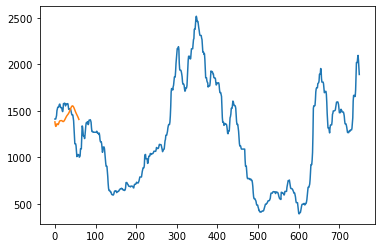

In [10]:
plt.plot(data)
plt.plot(total)